In [2]:
from astropy.table import Table
from astropy.io import fits
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import gaussian_kde
from minisom import MiniSom
import pickle
import os

In [3]:
df_L3_info = Table.read('../dataset/L3_COSMOS2020_Richard_RefCat_2023DEC4_info.fits')
df_L3_info = df_L3_info.to_pandas().sort_values(by = "cosmos_id")

photo_z = pd.read_csv('../dataset/COSMOS30k_photoz.csv').sort_values(by = "cosmos_id")

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/Noiseless_phot_cosmos_nolines_refcat30k.txt'
data_noiseless = np.loadtxt(fname)[:, 3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_shallow_nolines_refcat30k.txt'
data_all = np.loadtxt(fname)[:, 3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/NoisySphx_deep_nolines_refcat30k.txt'
data_deep = np.loadtxt(fname)[:, 3:]

fname = 'D:/SPHEREx_SOM/dataset/sphx_refcat/SPHEREx_1sigma_noise.txt'
data_1sig  = np.loadtxt(fname, skiprows=1)
wl = data_1sig[:,0]
sigma_all = data_1sig[:,1]
sigma_deep = data_1sig[:,2]

In [333]:
def basic_visual(file, save_diagram, mode, figure_size1 = 20, figure_size2 = 20):
    with open(file, "rb") as fh:
        record = pickle.load(fh)
        
    labels_map = record["prop_map"]
    data_type = record["type"]
    dim = record["dim"]
    sigma = record["sigma"]
    rate = record["rate"]
    iteration = record["iter"]
    b_scale = record["b_scale"]
    z_std_gal = record["z_std_gal"]
    som = record["som"]

    density_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map = np.zeros(dim ** 2).reshape(dim, dim)
    magnitude_map.fill(np.nan)
    z_map = np.zeros(dim ** 2).reshape(dim, dim)
    z_map.fill(np.nan)
    
    for i in labels_map.keys():
        properties = np.array(list(labels_map[i].keys()))
        means = np.mean(properties, axis = 0)
        medians = np.median(properties, axis = 0)
        stds = np.nanstd(properties, axis = 0, ddof = 1)
        density_map[int(list(i)[0]), int(list(i)[1])] = len(properties)
        if mode == "median":
            magnitude_map[int(list(i)[0]), int(list(i)[1])] = medians[0]
            z_map[int(list(i)[0]), int(list(i)[1])] = medians[1]
        else:
            magnitude_map[int(list(i)[0]), int(list(i)[1])] = means[0]
            z_map[int(list(i)[0]), int(list(i)[1])] = means[1]

    print(f"Mean z std: {round(np.nanmean(z_std_gal), 5)}")
        
    %matplotlib inline
    plt.close()
    plt.figure(figsize = (figure_size1, figure_size1 * 1.2))
    plt.pcolor(density_map.T, cmap='YlGn')
    plt.colorbar(orientation='horizontal', location='top')
    plt.title("Density Map")

    if  save_diagram:
        plt.savefig(f"D:/SPHEREx_SOM/final_presentation/density/{data_type}_{dim}_{float(sigma)}_{float(rate)}_{iteration}_{b_scale}.jpg", bbox_inches = "tight")
    plt.show()

    %matplotlib inline
    plt.close()
    plt.figure(figsize = (figure_size2 * 1.618 * 1.75, figure_size2))
    plt.subplot(121)
    plt.pcolor(magnitude_map.T, cmap="plasma" + "_r")
    plt.colorbar()
    plt.title("Median HSC i-band AB magnitude")

    plt.subplot(122)
    plt.pcolor(z_map.T, cmap="plasma")
    plt.colorbar()
    plt.title("Median True Redshift")
    plt.subplots_adjust(hspace=0, wspace=0)

    if  save_diagram:
        plt.savefig(f"D:/SPHEREx_SOM/final_presentation/i_z/{data_type}_{dim}_{float(sigma)}_{float(rate)}_{iteration}_{b_scale}.jpg", bbox_inches = "tight")
    plt.show()

In [20]:
def into_cell(data, err, info_data, file, save_diagram, positions, noiseless_data, wave = data_1sig[:, 0]):
    with open(file, "rb") as fh:
        record = pickle.load(fh)

    som = record["som"]
    b_scale = record["b_scale"]
    dim = record["dim"] 
    lupmag = -np.arcsinh(data / (2 * b_scale  * err))
    proc_data = (lupmag - np.mean(lupmag, axis=0)) / np.std(lupmag, ddof = 1, axis=0)
    
    labels_map = record["prop_map"]

    properties = {}
    flux = []
    weights = som.get_weights()
    
    for i in labels_map.keys():
        if i in positions:
            properties[i] = np.array(list(labels_map[i].keys()))
            flux.append(np.max(data[properties[i][:, 2].astype(np.int32)] * 1000))
            flux.append(np.min(data[properties[i][:, 2].astype(np.int32)] * 1000))

    for i in properties.keys():
        plt.close()
        plt.figure(figsize = (10, 3))
        colormap = plt.cm.rainbow

        for j in data[properties[i][:, 2].astype(np.int32)] * 1000:
            plt.plot(wave, j, marker = "", alpha = 0.3, color = "m")
            # plt.plot(wave, np.sinh(-((weights[i[0], i[1]]) * np.std(lupmag, ddof = 1, axis=0) + np.mean(lupmag, axis=0))) * (2 * b_scale  * err[0]) * 1000, marker = "", lw = 2, c = 'y', label = "Weight", ls = "-")
        plt.xlabel(r"Wavelength ($\mathrm{\mu}$m)")
        plt.ylabel(r"Flux ($\mathrm{\mu}$Jy)")
        plt.ylim(np.min(flux) - (np.max(flux) - np.min(flux)) * 0.05, np.max(flux) + (np.max(flux) - np.min(flux)) * 0.05)
        if save_diagram != False:
            plt.savefig("D:/SPHEREx_SOM/final_presentation/spectra/" + file.split("/")[-1].replace(".pkl", "") + "_" + str((i[0], i[1])) + "_" + "photo.jpg", bbox_inches = "tight")
        plt.show()

In [335]:
def std_map(photo_z, file, save_diagram):
    with open(file, "rb") as fh:
        record = pickle.load(fh)
    dim = record["dim"]

    z_std = np.zeros(dim ** 2).reshape(dim, dim)
    z_std.fill(np.nan)

    photo_z_std = np.zeros(dim ** 2).reshape(dim, dim)
    photo_z_std.fill(np.nan)

    labels_map = record["prop_map"]
    z_std_gal = np.array([])

    for i in labels_map.keys():
        properties = np.array(list(labels_map[i].keys()))
        stds = np.std(properties, axis = 0, ddof = 1)
        z_std[int(list(i)[0]), int(list(i)[1])] = np.mean(stds[1] / (properties[:, 1] + 1))
        z_std_gal = np.concatenate((z_std_gal, stds[1] / (properties[:, 1] + 1)))
        indices = properties[:, 2].astype(np.int32)
        if "shallow" in record["type"]:
            photo_z_std[int(list(i)[0]), int(list(i)[1])] = np.nanmean(photo_z["z_phot_sigma_std"].to_numpy()[indices] / (1 + photo_z["z_true"].to_numpy()[indices]))
        elif "deep" in record["type"]:
            photo_z_std[int(list(i)[0]), int(list(i)[1])] = np.nanmean(photo_z["z_phot_sigma_std_deep_nolines"].to_numpy()[indices] / (1 + photo_z["z_true"].to_numpy()[indices]))
            
    print(f"Mean redshift std: {np.nanmean(z_std_gal)}")
    print(f"std < 0.003: {z_std_gal[z_std_gal < 0.003].shape[0] * 30000 / 2 / 10 ** 6}")
    print(f"std < 0.01: {z_std_gal[z_std_gal < 0.01].shape[0] * 30000 / 2 / 10 ** 6}")
    print(f"std < 0.03: {z_std_gal[z_std_gal < 0.03].shape[0] * 30000 / 2 / 10 ** 6}")
    print(f"std < 0.1: {z_std_gal[z_std_gal < 0.1].shape[0] * 30000 / 2 / 10 ** 6}")
    print(f"std < 0.2: {z_std_gal[z_std_gal < 0.2].shape[0] * 30000 / 2 / 10 ** 6}")

    %matplotlib inline
    plt.figure(figsize = (5* 1.618, 5))
    plt.pcolor(photo_z_std.T, cmap='YlGn') 
    plt.colorbar()
    plt.title(r"$\sigma_z / (1+<z>)$")
    plt.show()

    plt.close()
    plt.figure(figsize = (5* 1.618, 5))
    plt.pcolor(z_std.T, cmap='YlGn') 
    plt.colorbar()
    plt.title(r"$\sigma_z / (1+<z>)$")
    plt.show()

    plt.figure(figsize = (5 * 1.618, 5))
    if "shallow" in record["type"]:
        plt.hist(photo_z["z_phot_sigma_std"] / (1 + deep_photo_z["z_true"]), bins = 50, alpha = 0.6, color='#1abc9c')
    elif "deep" in record["type"]:
        plt.hist(photo_z["z_phot_sigma_std_deep_nolines"] / (1 + deep_photo_z["z_true"]), bins = 50, alpha = 0.6, color='#1abc9c')
    plt.axvline(x = np.nanmean(z_std_gal), c ='#f1c40f', label = "Mean", lw = 2)
    plt.axvline(x = np.nanmedian(z_std_gal), c = '#e74c3c', label = "Median", lw = 2)
    plt.xlim(np.nanmin(z_std_gal) - 0.1 , np.nanmax(z_std_gal) + 0.1)
    plt.legend()
    plt.title("Redshift STD Histogram")
    plt.xlabel(r"$\sigma_z / (1+z)$")
    plt.ylabel("# of galaxies")
    plt.show()

    plt.figure(figsize = (5 * 1.618, 5))
    plt.hist(z_std_gal, bins = 50, alpha = 0.6, color='#1abc9c')
    plt.axvline(x = np.nanmean(z_std_gal), c ='#f1c40f', label = "Mean", lw = 2)
    plt.axvline(x = np.nanmedian(z_std_gal), c = '#e74c3c', label = "Median", lw = 2)
    plt.xlim(np.nanmin(z_std_gal) - 0.1 , np.nanmax(z_std_gal) + 0.1)
    plt.legend()
    plt.title("Redshift STD Histogram")
    plt.xlabel(r"$\sigma_z / (1+z)$")
    plt.ylabel("# of galaxies")
    if save_diagram:
        plt.savefig("D:/SPHEREx_SOM/record/4th_exploration/std_map/" + file.split("/")[-1].replace(".pkl", "") + "_" + "std_map.jpg", bbox_inches = "tight")
    plt.show()

In [70]:
def mapping(shallow_file, deep_file, shallow_data, deep_data, shallow_err, deep_err, shallow_position, info_data, bin_size = 3, save_diagram = False):
    def luptitude(data, err, b_scale):
        lupmag = -np.arcsinh(data / (2 * b_scale  * err))
        proc_err = np.absolute(-1 / (2 * b_scale  * shallow_err) / np.sqrt((data / (2 * b_scale * err)) ** 2 + 1) * err)
        proc_data = (lupmag- np.mean(lupmag, axis=0)) / np.std(lupmag, ddof = 1, axis=0)
        proc_err = proc_err / np.std(lupmag, ddof = 1, axis=0)

        return proc_data, proc_err

    def grid_points(position, bin_size):
        x = np.arange(position[0] - bin_size // 2, position[0] + bin_size // 2 + 1)
        y = np.arange(position[1] - bin_size // 2, position[1] + bin_size // 2 + 1)
        xv, yv = np.meshgrid(x, y)
        
        return [tuple(i) for i in list(np.concatenate((xv.reshape(-1, 1),yv.reshape(-1, 1)), axis = -1))]
        
    with open(shallow_file, "rb") as fh:
        shallow = pickle.load(fh)

    with open(deep_file, "rb") as fh:
        deep = pickle.load(fh)
        
    shallow_som = shallow["som"]
    deep_som = deep["som"]
    
    dim = shallow["dim"]
    
    shallow_b_scale = shallow["b_scale"]
    deep_b_scale = deep["b_scale"]
    
    shallow_proc_data, shallow_proc_err = luptitude(data = shallow_data, err = shallow_err, b_scale = shallow_b_scale )
    deep_proc_data, deep_proc_err = luptitude(data = deep_data, err = deep_err, b_scale = deep_b_scale )


    shallow_labels_map = shallow["prop_map"]
    deep_labels_map = deep["prop_map"]
    
    shallow_positions = grid_points(position = shallow_position, bin_size = bin_size)

    shallow_redshifts = np.array([])
    indices = np.array([])
    for i in shallow_labels_map.keys():
        if i in shallow_positions:
            shallow_properties = np.array(list(shallow_labels_map[i].keys()))
            indices = np.concatenate((indices, shallow_properties[:, 2].astype(np.int32)))
            shallow_redshifts = np.concatenate((shallow_redshifts, shallow_properties[:, 1]))
    
    shallow_density = gaussian_kde(shallow_redshifts)

    mapped_cells = []
    for i in indices.astype(np.int32):
        mapped_cells.append(deep_som.winner(deep_proc_data[i], deep_proc_err[i]))

    deep_positions, counts = np.unique(np.array(mapped_cells), return_counts = True, axis = 0)

    deep_densitys = []
    for i in deep_positions:    
        if (i[0], i[1]) in deep_labels_map.keys():
            deep_densitys.append(gaussian_kde(np.array(list(deep_labels_map[(i[0], i[1])].keys()))[:, 1]))
        else:
            pass

    z_range = np.linspace(np.min(info_data["z_true"]), np.max(info_data["z_true"]), 1000)
    deep_pdfs = []
    for i in range(len(deep_positions)):
        deep_pdfs.append(deep_densitys[i](z_range))
        
    combined_pdf = (counts / np.sum(counts)).reshape(-1, 1) * np.array(deep_pdfs)
    rescale1 = 1 / np.sum((z_range[1] - z_range[0]) * shallow_density(z_range))
    rescale2 = 1 / np.sum((z_range[1] - z_range[0]) * np.sum(combined_pdf , axis = 0))
    
    plt.figure(figsize = (5 * 1.618, 5))
    plt.plot(z_range, shallow_density(z_range) * rescale1, lw = 2, c = "k", label = "Original PDF")
    plt.plot(z_range, np.sum(combined_pdf , axis = 0) * rescale2, lw = 2, c = "r", label = "Combined PDF")
    plt.xlabel("True Redshift")
    plt.ylabel("p(z)")
    plt.legend()
    if save_diagram:
        plt.savefig(f"D:/SPHEREx_SOM/record/5th_exploration/mapping/pdf_comparison.jpg", bbox_inches = "tight")
    plt.show()
    print()

    return deep_positions, counts, deep_pdfs, combined_pdf

In [37]:
def bin_cells(data, err, info_data, file, save_diagram, position, bin_size = 3, pdf = False):
    with open(file, "rb") as fh:
        record = pickle.load(fh)

    som = record["som"]
    b_scale = record["b_scale"]
    dim = record["dim"] 
    lupmag = -np.arcsinh(data / (2 * b_scale  * err))
    proc_data = (lupmag - np.mean(lupmag, axis=0)) / np.std(lupmag, ddof = 1, axis=0)
    
    if len(list(list(record["prop_map"].items())[0][1].keys())[0]) != 3:
        proc_err = np.absolute(-1 / (2 * b_scale  * err) / np.sqrt((data / (2 * b_scale * err)) ** 2 + 1) * err)
        proc_err = proc_err / np.std(lupmag, ddof = 1, axis=0)
    
        print(f"Topological error: {som.topographic_error(proc_data)}")
        print(f"Quantization error: {som.quantization_error(proc_data)}")
        print(f"Topological error: {record["topo_err"]}")
        print(f"Quantization error: {record["quan_err"]}")
        
        labels_map = som.labels_map(proc_data, proc_err, tuple(map(tuple, np.concatenate((np.expand_dims(info_data["HSC_i_MAG"].values, axis = 1), 
                                                                                          np.expand_dims(info_data["z_true"].values, axis = 1), 
                                                                                          np.expand_dims(np.array([i for i in range(0, proc_data.shape[0])]), axis = 1)), axis = -1))))
        record["prop_map"] = labels_map
        
        try:
            with open(file, 'wb') as fh:
                pickle.dump(record, fh, protocol=pickle.HIGHEST_PROTOCOL)
        except KeyboardInterrupt:
            print('KeyboardInterrupt caught, data saved.')
    else:
        labels_map = record["prop_map"]

    x = np.arange(position[0] - bin_size // 2, position[0] + bin_size // 2 + 1)
    y = np.arange(position[1] - bin_size // 2, position[1] + bin_size // 2 + 1)
    xv, yv = np.meshgrid(x, y)
    positions = [tuple(i) for i in list(np.concatenate((xv.reshape(-1, 1),yv.reshape(-1, 1)), axis = -1))]

    bin_redshifts = np.array([])
    
    for i in labels_map.keys():
        if i in positions:
            properties = np.array(list(labels_map[i].keys()))
            z_min = np.min(properties[:, 1])
            z_max = np.max(properties[:, 1])
            bin_redshifts = np.concatenate((bin_redshifts, properties[:, 1]))

    plt.figure(figsize = (5 * 1.618, 5))
    plt.hist(bin_redshifts, bins = 30, range = (np.min(info_data["z_true"]), np.max(info_data["z_true"])), density = True, alpha = 0.6, color='#1abc9c')
    if pdf:
        density = gaussian_kde(bin_redshifts)
        z_range = np.linspace(np.min(info_data["z_true"]), np.max(info_data["z_true"]), 1000)
        pdf = density(z_range)
        plt.plot(z_range, pdf, lw = 2, c = '#9b59b6')
    plt.xlabel("True Redshift")
    plt.ylabel("p(z)")
    plt.title(f"# galaxies: {len(bin_redshifts)}")
    plt.show()

In [38]:
shallow_data = pd.DataFrame(data_all[:, 0::2]).dropna().to_numpy()
shallow_info = df_L3_info[-pd.DataFrame(data_all[:, 0::2]).isna()[0]]
shallow_photo_z = photo_z[-pd.DataFrame(data_all[:, 0::2]).isna()[0]]
shallow_noiseless = data_noiseless[-pd.DataFrame(data_all[:, 0::2]).isna()[0]]
shallow_err = np.tile(data_all[0, 1::2],  (shallow_data.shape[0], 1))

deep_data = pd.DataFrame(data_deep[:, 0::2]).dropna().to_numpy()
deep_info = df_L3_info[-pd.DataFrame(data_deep[:, 0::2]).isna()[0]]
deep_photo_z = photo_z[-pd.DataFrame(data_deep[:, 0::2]).isna()[0]]
deep_noiseless = data_noiseless[-pd.DataFrame(data_deep[:, 0::2]).isna()[0]]
deep_err = np.tile(data_deep[0, 1::2],  (deep_data.shape[0], 1))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_3596\2657407693.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  shallow_info = df_L3_info[-pd.DataFrame(data_all[:, 0::2]).isna()[0]]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_3596\2657407693.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  shallow_photo_z = photo_z[-pd.DataFrame(data_all[:, 0::2]).isna()[0]]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_3596\2657407693.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  deep_info = df_L3_info[-pd.DataFrame(data_deep[:, 0::2]).isna()[0]]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_3596\2657407693.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  deep_photo_z = photo_z[-pd.DataFrame(data_deep[:, 0::2]).isna()[0]]


In [39]:
basic_visual(file = "D:/SPHEREx_SOM/record/6th_exploration/SOM/chi2_lup_deep_70_1.3_1_5_10.pkl", save_diagram = True, mode = "median", figure_size1 = 5, figure_size2 = 6)

NameError: name 'basic_visual' is not defined

In [ ]:
into_cell(data = deep_data, err = deep_err, info_data = deep_info, file = "D:/SPHEREx_SOM/record/6th_exploration/SOM/chi2_lup_deep_70_1.3_1_5_10.pkl", save_diagram = True, positions = [(40, 27), (40, 29), (40, 65)], noiseless_data = deep_noiseless, wave = data_1sig[:, 0])

In [ ]:
for i in range(len(mapped_cells)):
    print(mapped_cells[i])
    print(counts[i])
    bin_cells(data = deep_data, err = deep_err, info_data = deep_info, position = (mapped_cells[i][0], mapped_cells[i][1]), file = "D:/SPHEREx_SOM/record/6th_exploration/SOM/chi2_lup_deep_70_1.3_1_5_10.pkl", bin_size = 1, save_diagram = False, pdf = False)

In [ ]:
weights = into_cell(data = shallow_data , err = shallow_err, info_data = shallow_info, positions = [(10, 10), (15, 40)], file = "D:/SPHEREx_SOM/record/6th_exploration/SOM/chi2_lup_shallow_70_1.4_0.6_3_1000.pkl", save_diagram = True, noiseless_data = deep_noiseless)

In [ ]:
std_map(photo_z = deep_photo_z, file = "D:/SPHEREx_SOM/record/6th_exploration/SOM/chi2_lup_deep_70_1.3_1_5_10.pkl", save_diagram = False)

In [ ]:
std_map(photo_z = shallow_photo_z, file = "D:/SPHEREx_SOM/record/6th_exploration/SOM/chi2_lup_shallow_70_1.4_0.6_3_1000.pkl", save_diagram = False)

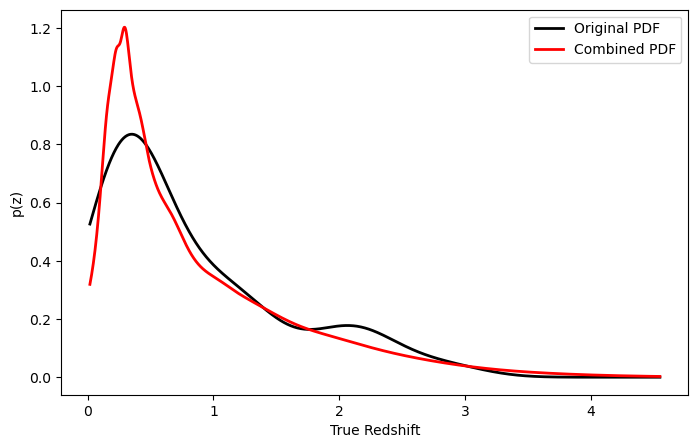

In [71]:
mapped_cells, counts, deep_pdfs, combined_pdf = mapping(shallow_file = "D:/SPHEREx_SOM/record/6th_exploration/SOM/chi2_lup_shallow_70_1.4_0.6_3_1000.pkl",
                           deep_file = "D:/SPHEREx_SOM/record/6th_exploration/SOM/chi2_lup_deep_70_1.3_1_5_10.pkl", shallow_data = shallow_data,
                           deep_data = deep_data, shallow_err = shallow_err, deep_err = deep_err, shallow_position = (20, 4), info_data = shallow_info, save_diagram = False, bin_size = 3)

In [68]:
from matplotlib.colors import LinearSegmentedColormap
def basic_visual(dim, positions):
    cells = np.zeros(dim ** 2).reshape(dim, dim)
    cells.fill(np.nan)
    
    for i in positions:
        cells[int(i[0]), int(i[1])] = 1
    
    %matplotlib inline
    plt.close()
    white_cmap = LinearSegmentedColormap.from_list('white_cmap', ['white', 'white'])
    plt.figure(figsize = (5, 5 * 1.2))
    plt.pcolor(cells.T, cmap = white_cmap, alpha = 1, lw = 1, edgecolor = "k")
    plt.colorbar(orientation='horizontal', location='top')
    plt.title("Density Map")
    plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_3596\4212350407.py:14: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(orientation='horizontal', location='top')


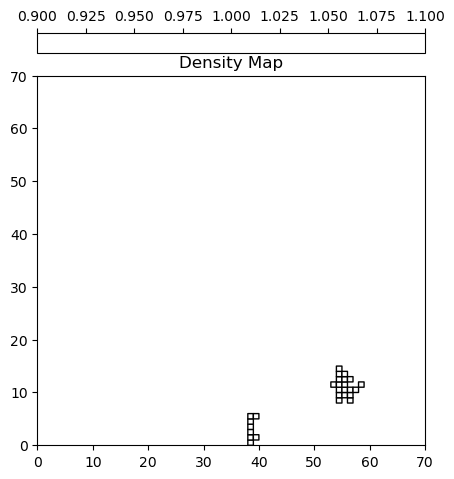

In [69]:
basic_visual(dim = 70, positions= mapped_cells)

In [ ]:
plt.figure(figsize = (4 * 1.618, 4))
x_range = np.linspace(-1, 8, 1000)
plt.axvline(x = 0, c = "k", lw = 1)
plt.axhline(y = 0, c = "k", lw = 1)
plt.plot(x_range, -np.log(2 * x_range), lw = 2, ls = "--", label = r"-ln(2x)")
plt.plot(x_range, -x_range, lw = 2, ls = "--", label = r"-x")
plt.plot(x_range, -np.arcsinh(x_range), lw = 2, c = "r", label = r"-sinh(x)")
plt.legend()
plt.grid()

In [ ]:
plt.figure(figsize = (6 * 2, 6))
plt.subplot(221)
plt.plot(data_1sig[:, 0], deep_data[9614])
plt.ylim(np.min(shallow_data[9614]) - (np.max(shallow_data[9614]) - np.min(shallow_data[9614])) * 0.1, np.max(shallow_data[9614]) + (np.max(shallow_data[9614]) - np.min(shallow_data[9614])) * 0.1)
plt.ylabel(r"Flux (mJy)")

plt.subplot(222)
plt.plot(data_1sig[:, 0], shallow_data[9614])
plt.ylim(np.min(shallow_data[9614]) - (np.max(shallow_data[9614]) - np.min(shallow_data[9614])) * 0.1, np.max(shallow_data[9614]) + (np.max(shallow_data[9614]) - np.min(shallow_data[9614])) * 0.1)
plt.yticks([])

plt.subplot(223)
plt.plot(data_1sig[:, 0], deep_data[0])
plt.ylim(np.min(shallow_data[0]) - (np.max(shallow_data[0]) - np.min(shallow_data[0])) * 0.1, np.max(shallow_data[0]) + (np.max(shallow_data[0]) - np.min(shallow_data[0])) * 0.1)
plt.xlabel(r"Wavelength ($\mathrm{\mu}$m)")
plt.ylabel(r"Flux (mJy)")

plt.subplot(224)
plt.plot(data_1sig[:, 0], shallow_data[0])
plt.ylim(np.min(shallow_data[0]) - (np.max(shallow_data[0]) - np.min(shallow_data[0])) * 0.1, np.max(shallow_data[0]) + (np.max(shallow_data[0]) - np.min(shallow_data[0])) * 0.1)
plt.xlabel(r"Wavelength ($\mathrm{\mu}$m)")
plt.yticks([])

plt.subplots_adjust(hspace=0, wspace=0)

In [ ]:
np.random.seed(314159)
a = np.random.rand(31, 31)
plt.close()
plt.figure(figsize = (5, 5 * 1.2))
plt.pcolor(a.T, cmap = 'YlGn')
plt.colorbar(orientation='horizontal', location='top')
plt.show()

x = np.linspace(-15, 15, 31)
y = np.linspace(-15, 15, 31)
X, Y = np.meshgrid(x, y)

def gaussian(x, y, mu_x, mu_y, sigma):
    return np.exp(-((x - mu_x)**2 + (y - mu_y)**2) / (2 * sigma**2))

mu_x, mu_y = 0, 0  # Center of the Gaussian
sigma = 5  # Standard deviation

Z = gaussian(X, Y, mu_x, mu_y, sigma)

plt.figure(figsize = (5, 5 * 1.2))
plt.pcolor(Z, shading='auto')
plt.colorbar(orientation='horizontal', location='top')
plt.show()

plt.close()
plt.figure(figsize = (5, 5 * 1.2))
plt.pcolor((a-b*Z).T, cmap = 'YlGn')
plt.colorbar(orientation='horizontal', location='top')
plt.show()

np.random.seed(31415926)
b = np.random.rand(31, 31)
plt.close()
plt.figure(figsize = (5, 5 * 1.2))
plt.pcolor(a.T, cmap = 'YlGn')
plt.colorbar(orientation='horizontal', location='top')
plt.show()

In [ ]:
plt.figure(figsize = (6 * 1.618, 6))
plt.errorbar(data_1sig[:, 0], shallow_data[9614], yerr = sigma_all / 1000, capsize = 3, marker = ".", elinewidth = 2, alpha = 0.5, lw = 0, label = "All-sky", capthick = 2)
plt.errorbar(data_1sig[:, 0], deep_data[9614], yerr = sigma_deep / 1000, capsize = 3, marker = ".", elinewidth = 2, alpha = 0.5, lw = 0, label = "Deep field", capthick = 2)
plt.legend(fontsize = 17)
plt.ylabel(r"Flux (mJy)", fontsize = 15)
plt.xlabel(r"Wavelength ($\mathrm{\mu}$m)", fontsize = 15)

In [ ]:
import numpy as np
from scipy.stats import rv_continuous

class CustomPDF(rv_continuous):
    def _pdf(self, x):
        return np.where(x >= 0, np.exp(-x), 0)

# Create an instance of the custom PDF
custom_pdf = CustomPDF(name='custom_pdf')

# Plot the PDF
import matplotlib.pyplot as plt
x = np.linspace(-1, 5, 1000)
plt.plot(x, custom_pdf.pdf(x))
plt.title('Custom PDF')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.show()